In [14]:
import sys
sys.path.insert(0, '../../../pyLDLE2/')
sys.path.insert(0, '../src/')

import numpy as np
import networkx as nx
import ConnectionNetworkX as cnx

from matplotlib import pyplot as plt
from matplotlib import cm

from pyLDLE2 import datasets, visualize_, util_

In [2]:
import importlib
importlib.reload(cnx)

<module 'ConnectionNetworkX' from '/home/dhruv/codebase/cgw/connection-graph-wasserstein/nbks/../src/ConnectionNetworkX.py'>

In [3]:
def draw3d(G, pos, node_color, node_size, edge_color, edge_width=1, figsize=(8,4)):
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    # Create the 3D figure
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, c=node_color, s=node_size, ec="w")

    # Plot the edges
    for i in range(edge_xyz.shape[0]):
        vizedge = edge_xyz[i,:]
        direction = [vizedge[1,0]-vizedge[0,0],
                     vizedge[1,1]-vizedge[0,1],
                     vizedge[1,2]-vizedge[0,2]]
        direction = np.array(direction)
        edge_length = np.linalg.norm(direction)
        direction = direction/edge_length
        ax.quiver(vizedge[0,0], vizedge[0,1], vizedge[0,2],
                  direction[0], direction[1], direction[2],
                  length=edge_length, color=edge_color[i])
        #ax.plot(*vizedge.T, color=edge_color[i], linewidth=edge_width)

    visualize_.set_axes_equal(ax)
    ax.set_xlim(np.min(node_xyz[:,0]), np.max(node_xyz[:,0]))
    ax.set_ylim(np.min(node_xyz[:,1]), np.max(node_xyz[:,1]))
    ax.set_zlim(np.min(node_xyz[:,2]), np.max(node_xyz[:,2]))
    ax.axis('off')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.margins(0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Load data

In [4]:
X, labelsMat, _ = datasets.Datasets().curvedtorus3d(n=3000)

X.shape =  (3000, 3)


In [15]:
s_d_e, pred = util_.shortest_paths(X, 10)

<IPython.core.display.Javascript object>


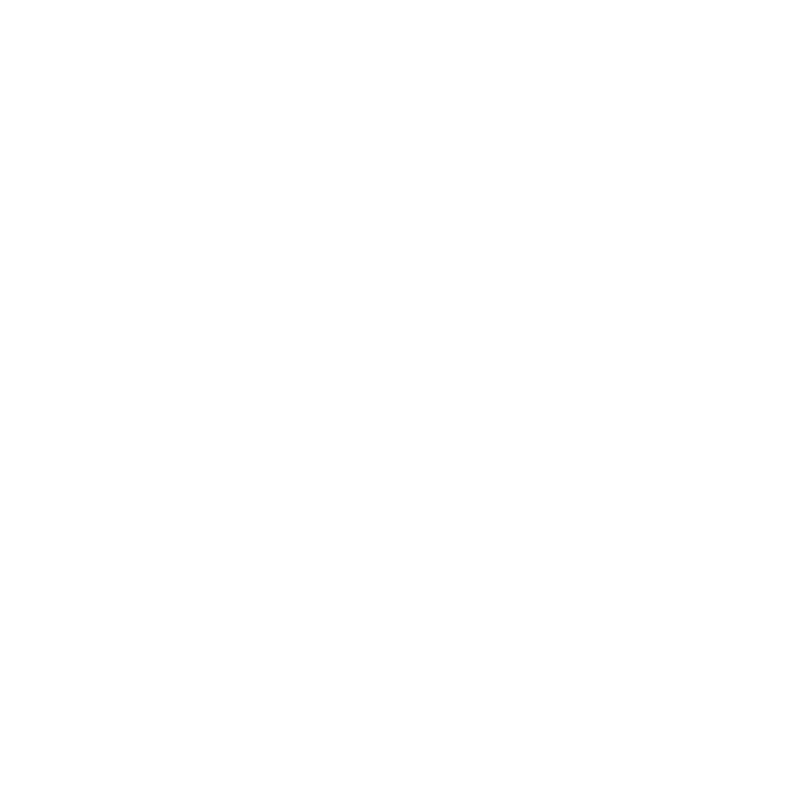

In [8]:
%matplotlib notebook
vis = visualize_.Visualize()
vis.data(X, labelsMat[:,0], cmap='hsv', figsize=(4,4))

# Set source and destination nodes

In [9]:
source = 1300
dest1 = 100
dest2 = 1929

<IPython.core.display.Javascript object>


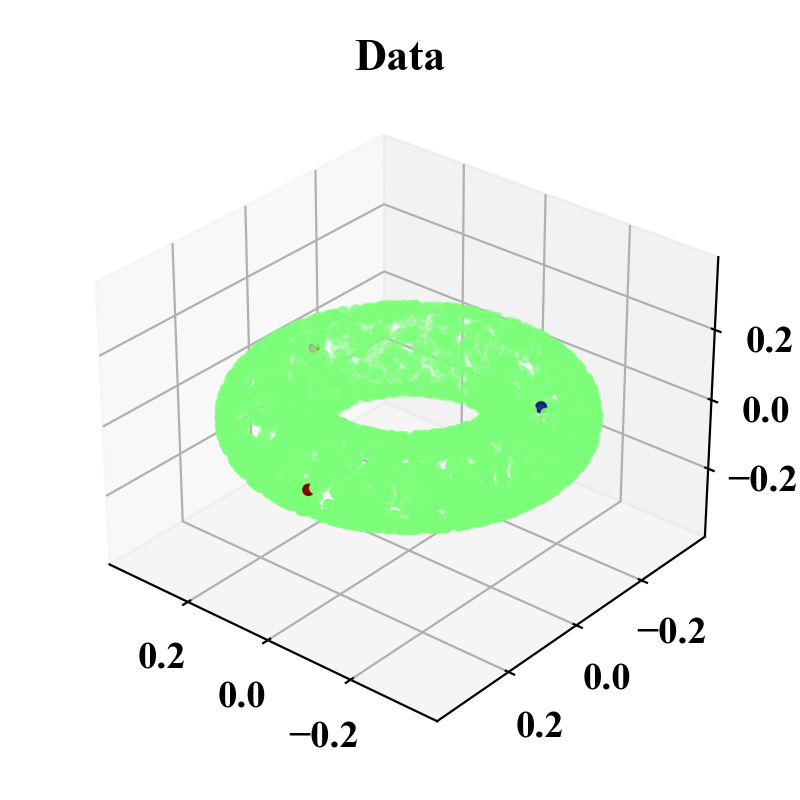

In [10]:
%matplotlib notebook
vis = visualize_.Visualize()
labels = np.zeros(X.shape[0])
labels[source] = -1
labels[dest1] = 1
labels[dest2] = 1
vis.data(X, labels, cmap='jet', figsize=(4,4), s=50, elev=30, azim=130)

#  Build connection graph

In [11]:
eps_pca = 0.03
eps = eps_pca
d = 2
CG = cnx.cnxFromData(X, eps_pca, eps, d=d, tol=1, triv_sigma=False)

Total edges before removal: 12613


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 4245.77it/s]


Proportion of edges which were removed due to remoteness:  0.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:12<00:00, 41.18it/s]


# Set B, w, mu, nu, c

In [53]:
n = CG.number_of_nodes()

B = CG.B.T.astype('float32')
w = np.array(list(nx.get_edge_attributes(CG, 'weight').values()))

sigma1 = 0.1
sigma2 = 0.1
mu = np.zeros((n, d))
mu[:,0] = np.exp(-s_d_e[source,:]**2/sigma1**2)
mu[:,1] = np.exp(-s_d_e[source,:]**2/sigma2**2)
mu = mu/np.sum(mu, axis=0)[None,:]
mu = mu.flatten()

nu = np.zeros((n, d))
nu[:,0] = np.exp(-s_d_e[dest1,:]**2/sigma1**2)
nu[:,1] = np.exp(-s_d_e[dest2,:]**2/sigma2**2)
nu = nu/np.sum(nu, axis=0)[None,:]
nu = nu.flatten()

c = (mu - nu)

# Plot c

<IPython.core.display.Javascript object>


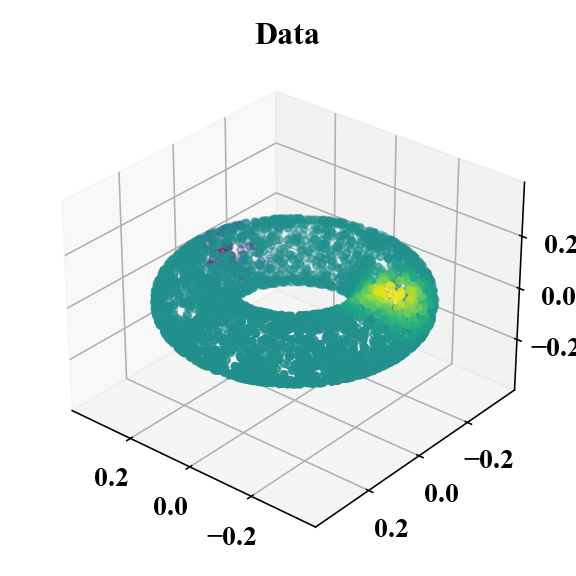

<IPython.core.display.Javascript object>


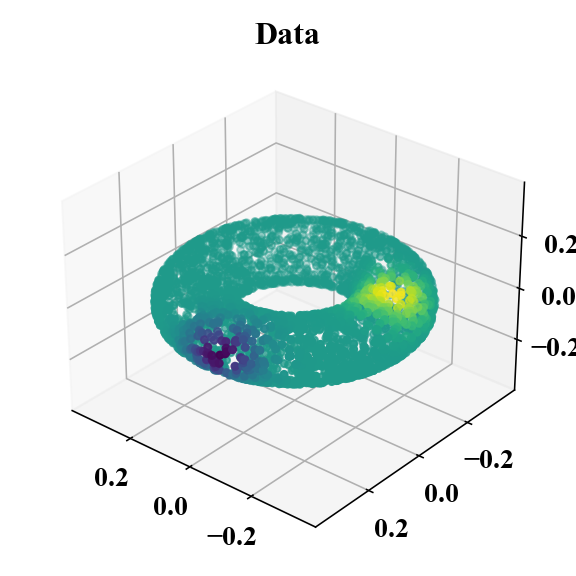

In [54]:
%matplotlib notebook
vis = visualize_.Visualize()
vis.data(X, c.reshape((n,d))[:,0], cmap='viridis', figsize=(4,4), s=50, elev=30, azim=130)
vis.data(X, c.reshape((n,d))[:,1], cmap='viridis', figsize=(4,4), s=50, elev=30, azim=130)

# Check feasibility of primal i.e. $B^TJ = c$

In [55]:
temp_J, residuals, _, _ = np.linalg.lstsq(B.T.toarray(), c, rcond=None)
print('Error is:', np.linalg.norm(c.flatten() - B.T.dot(temp_J).flatten())) # if this is small then feasible

Error is: 2.0510536781253263e-15


In [56]:
np.max(w)

0.16807888389961673

# Solve Beckmann dual using gradient descent

In [57]:
learning_rate = 0.01
alpha = np.max(w)*200
n_epochs = 5000

phi, phi0 = cnx.optimize_(B, w, c, learning_rate=learning_rate, alpha=alpha,
                    n_epochs=n_epochs, phi0='least_squares')

Initial loss: (tensor(-0.3493), tensor(0.0003))
epoch: 0, loss: -0.349262, loss0: -0.349267, loss1: 0.000346
epoch: 10, loss: -0.748892, loss0: -0.749186, loss1: 0.019761
epoch: 20, loss: -1.129394, loss0: -1.144814, loss1: 1.036713
epoch: 30, loss: -1.456732, loss0: -1.512236, loss1: 3.731663
epoch: 40, loss: -1.743529, loss0: -1.843717, loss1: 6.735789
epoch: 50, loss: -2.002531, loss0: -2.146634, loss1: 9.688306
epoch: 60, loss: -2.242084, loss0: -2.426979, loss1: 12.430786
epoch: 70, loss: -2.466469, loss0: -2.689805, loss1: 15.015230
epoch: 80, loss: -2.678697, loss0: -2.938887, loss1: 17.493000
epoch: 90, loss: -2.881001, loss0: -3.176810, loss1: 19.887682
epoch: 100, loss: -3.074811, loss0: -3.405313, loss1: 22.220127
epoch: 110, loss: -3.260998, loss0: -3.625584, loss1: 24.511690
epoch: 120, loss: -3.440201, loss0: -3.838846, loss1: 26.801521
epoch: 130, loss: -3.612854, loss0: -4.046153, loss1: 29.131329
epoch: 140, loss: -3.779427, loss0: -4.248176, loss1: 31.514717
epoch: 15

epoch: 1260, loss: -8.772556, loss0: -13.840226, loss1: 340.707306
epoch: 1270, loss: -8.776694, loss0: -13.867257, loss1: 342.246429
epoch: 1280, loss: -8.780678, loss0: -13.893763, loss1: 343.760620
epoch: 1290, loss: -8.784512, loss0: -13.919754, loss1: 345.250366
epoch: 1300, loss: -8.788204, loss0: -13.945241, loss1: 346.715546
epoch: 1310, loss: -8.791759, loss0: -13.970229, loss1: 348.156616
epoch: 1320, loss: -8.795177, loss0: -13.994728, loss1: 349.573822
epoch: 1330, loss: -8.798470, loss0: -14.018745, loss1: 350.967285
epoch: 1340, loss: -8.801634, loss0: -14.042288, loss1: 352.337311
epoch: 1350, loss: -8.804678, loss0: -14.065366, loss1: 353.684204
epoch: 1360, loss: -8.807606, loss0: -14.087985, loss1: 355.008118
epoch: 1370, loss: -8.810418, loss0: -14.110152, loss1: 356.309357
epoch: 1380, loss: -8.813122, loss0: -14.131876, loss1: 357.588074
epoch: 1390, loss: -8.815723, loss0: -14.153164, loss1: 358.844421
epoch: 1400, loss: -8.818221, loss0: -14.174023, loss1: 360.07

epoch: 2500, loss: -8.872165, loss0: -14.989162, loss1: 411.255249
epoch: 2510, loss: -8.872168, loss0: -14.990153, loss1: 411.321655
epoch: 2520, loss: -8.872173, loss0: -14.991112, loss1: 411.385742
epoch: 2530, loss: -8.872177, loss0: -14.992035, loss1: 411.447571
epoch: 2540, loss: -8.872181, loss0: -14.992922, loss1: 411.506958
epoch: 2550, loss: -8.872185, loss0: -14.993777, loss1: 411.564209
epoch: 2560, loss: -8.872187, loss0: -14.994600, loss1: 411.619415
epoch: 2570, loss: -8.872190, loss0: -14.995394, loss1: 411.672485
epoch: 2580, loss: -8.872193, loss0: -14.996154, loss1: 411.723389
epoch: 2590, loss: -8.872195, loss0: -14.996885, loss1: 411.772430
epoch: 2600, loss: -8.872198, loss0: -14.997591, loss1: 411.819702
epoch: 2610, loss: -8.872198, loss0: -14.998268, loss1: 411.865173
epoch: 2620, loss: -8.872201, loss0: -14.998920, loss1: 411.908875
epoch: 2630, loss: -8.872202, loss0: -14.999545, loss1: 411.950806
epoch: 2640, loss: -8.872203, loss0: -15.000146, loss1: 411.99

epoch: 3740, loss: -8.872220, loss0: -15.012975, loss1: 412.852478
epoch: 3750, loss: -8.872219, loss0: -15.012975, loss1: 412.852509
epoch: 3760, loss: -8.872221, loss0: -15.012977, loss1: 412.852570
epoch: 3770, loss: -8.872221, loss0: -15.012976, loss1: 412.852478
epoch: 3780, loss: -8.872222, loss0: -15.012976, loss1: 412.852417
epoch: 3790, loss: -8.872220, loss0: -15.012974, loss1: 412.852417
epoch: 3800, loss: -8.872219, loss0: -15.012975, loss1: 412.852539
epoch: 3810, loss: -8.872220, loss0: -15.012975, loss1: 412.852478
epoch: 3820, loss: -8.872221, loss0: -15.012976, loss1: 412.852448
epoch: 3830, loss: -8.872219, loss0: -15.012976, loss1: 412.852600
epoch: 3840, loss: -8.872220, loss0: -15.012975, loss1: 412.852478
epoch: 3850, loss: -8.872220, loss0: -15.012975, loss1: 412.852478
epoch: 3860, loss: -8.872221, loss0: -15.012976, loss1: 412.852478
epoch: 3870, loss: -8.872219, loss0: -15.012976, loss1: 412.852631
epoch: 3880, loss: -8.872219, loss0: -15.012978, loss1: 412.85

epoch: 4980, loss: -8.872219, loss0: -15.012997, loss1: 412.854004
epoch: 4990, loss: -8.872219, loss0: -15.012995, loss1: 412.853851


# Compute activeness of edges and optimal primal

In [58]:
edge_score = cnx.activenes_of_edges(phi, B, w, c)
J_opt = cnx.optimal_primal(phi, B, w, c, alpha, d) # the mean abs error should be small

mean abs err of sum_{v in V} ||(B^TJ-c)(v)||_1 0.0012613816837876014


In [59]:
J_opt_norm = np.linalg.norm(J_opt, axis=1)

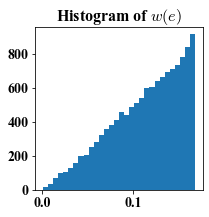

In [60]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(list(nx.get_edge_attributes(CG, "weight").values()), bins=30)
plt.title('Histogram of $w(e)$')
plt.show()

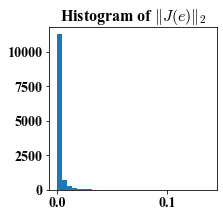

In [61]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(J_opt_norm, bins=30)
plt.title('Histogram of $\\left\\|J(e)\\right\\|_2$')
plt.show()

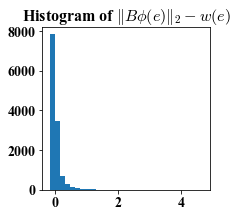

In [62]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(edge_score, bins=30)
plt.title('Histogram of $\\left\\|B\\phi(e)\\right\\|_2-w(e)$')
plt.show()

# Plot optimal flow

In [63]:
from sklearn.manifold import LocallyLinearEmbedding, Isomap

to_embed = None # no need to embed if the data is already in <= 3 dimensions, else use isomap/ltsa
embed_dim = None
if to_embed is not None:
    if to_embed == 'isomap':
        fit_obj = Isomap(n_components=embed_dim, n_neighbors=10)
    else:
        fit_obj = LocallyLinearEmbedding(n_components=embed_dim, n_neighbors=10, method='ltsa')
    embedding = fit_obj.fit_transform(X)
else:
    embedding = X

In [64]:
J = J_opt

<IPython.core.display.Javascript object>


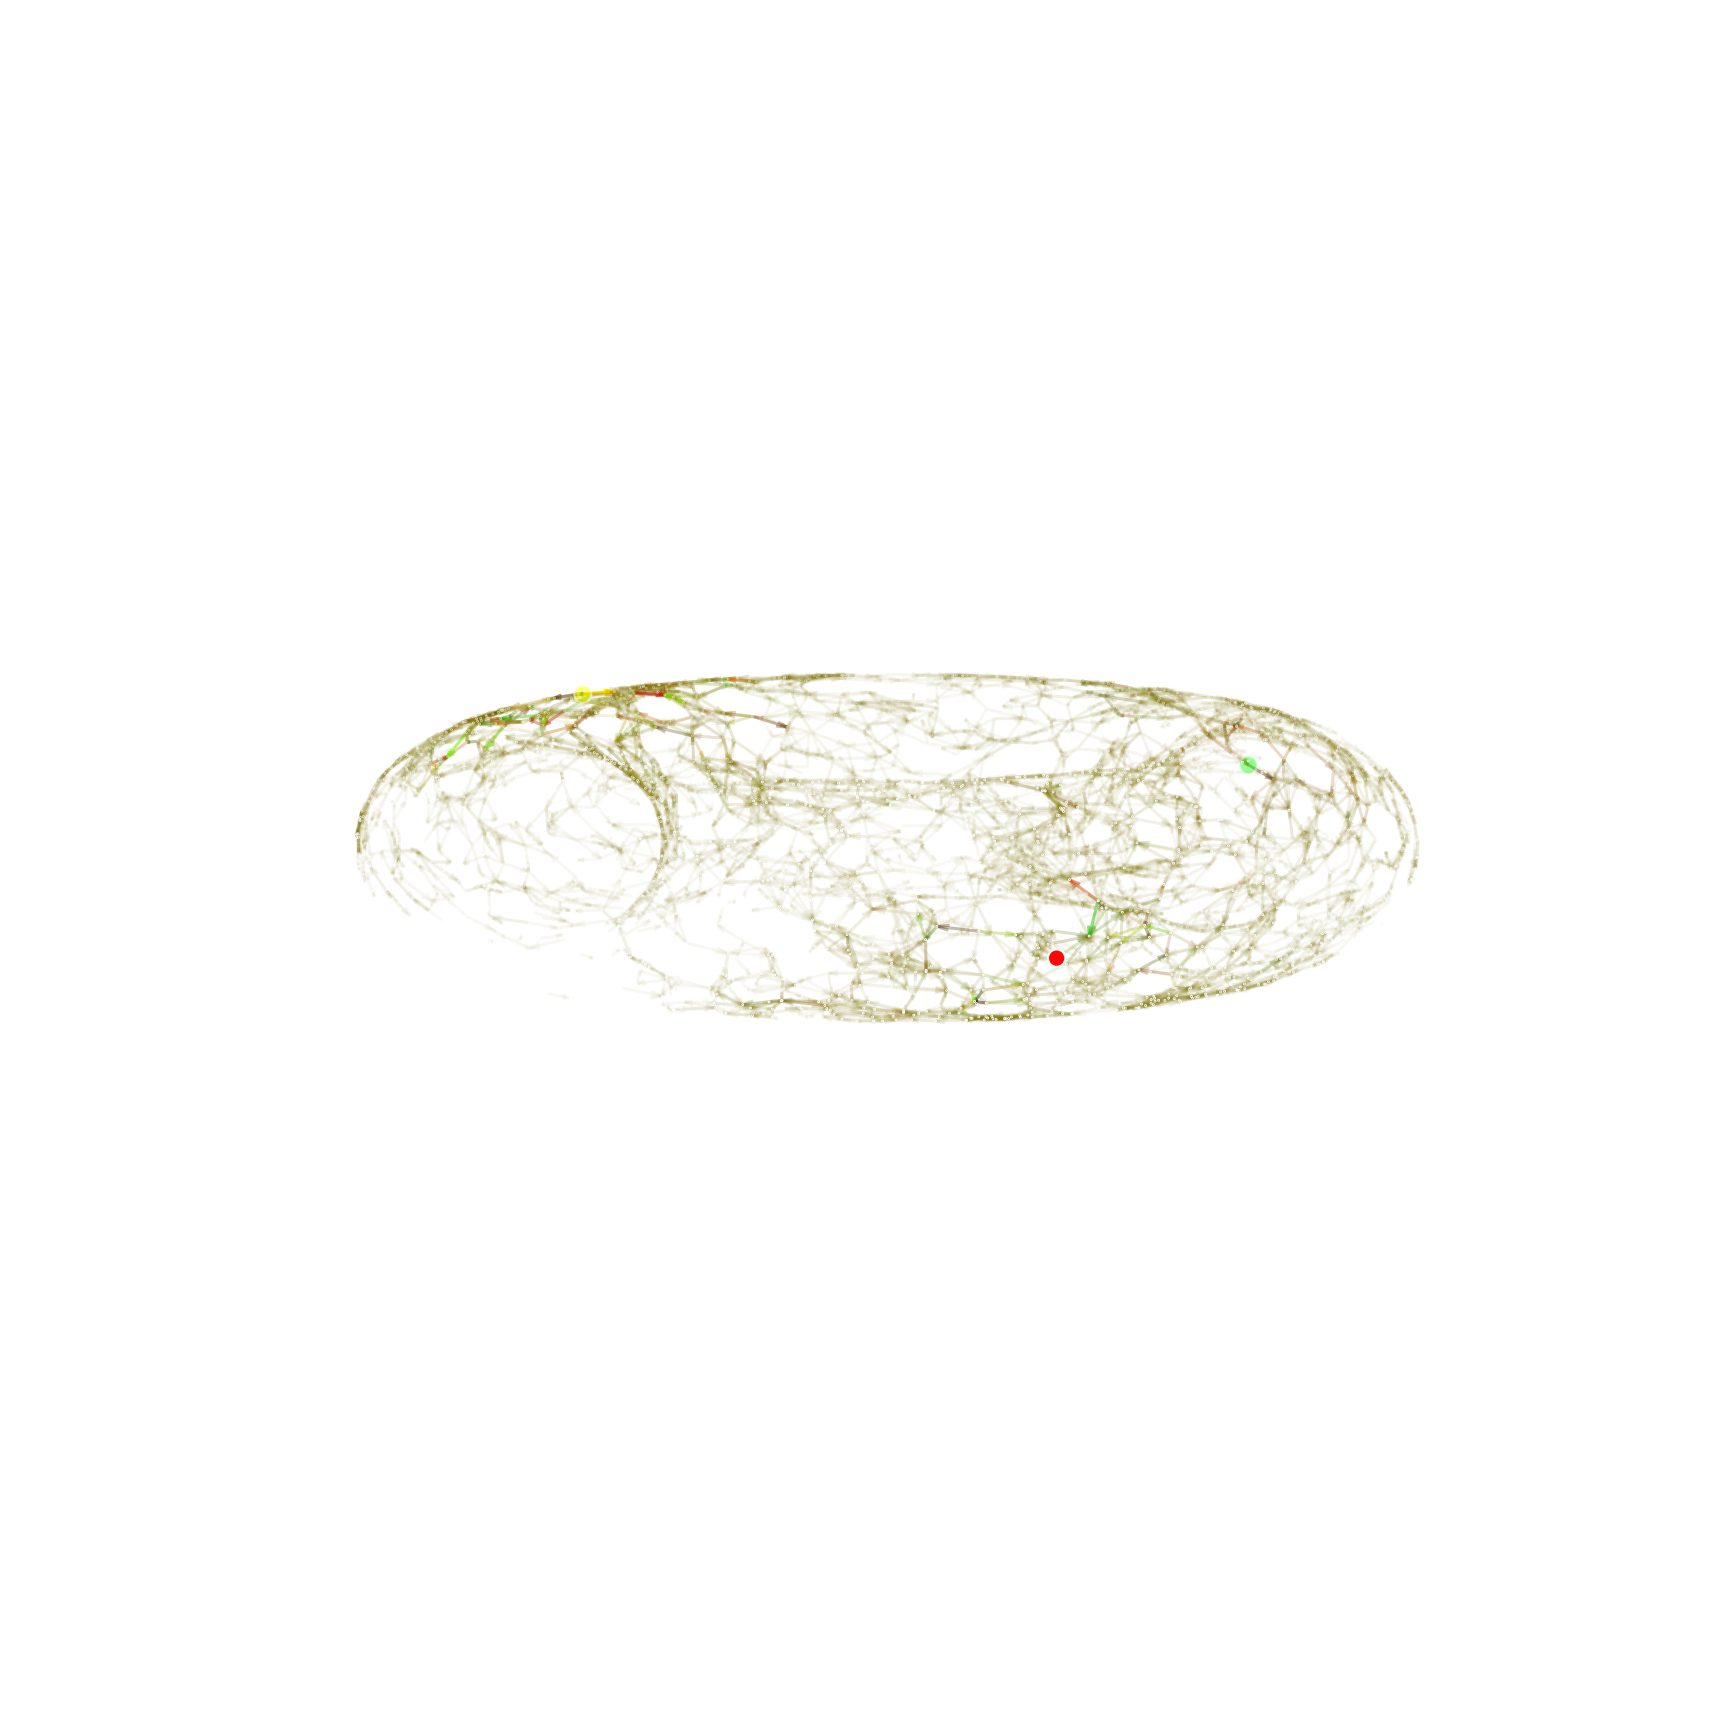

/tmp/ipykernel_71977/1841123288.py:32: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [65]:
%matplotlib notebook

node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300

node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,1,0,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,1,0,1]

mask = (edge_score > 0)
J_ = J[mask,:]

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,0] = cm.Greys((J_[:,0]-np.min(J_[:,0]))/np.ptp(J_[:,0]))[:,0]
edge_color[mask,1] = cm.Greys((J_[:,1]-np.min(J_[:,1]))/np.ptp(J_[:,1]))[:,1]
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=5, figsize=(12, 12))
#plt.gca().view_init(elev=20, azim=-119)
visualize_.set_axes_equal(plt.gca())
plt.show()

<IPython.core.display.Javascript object>


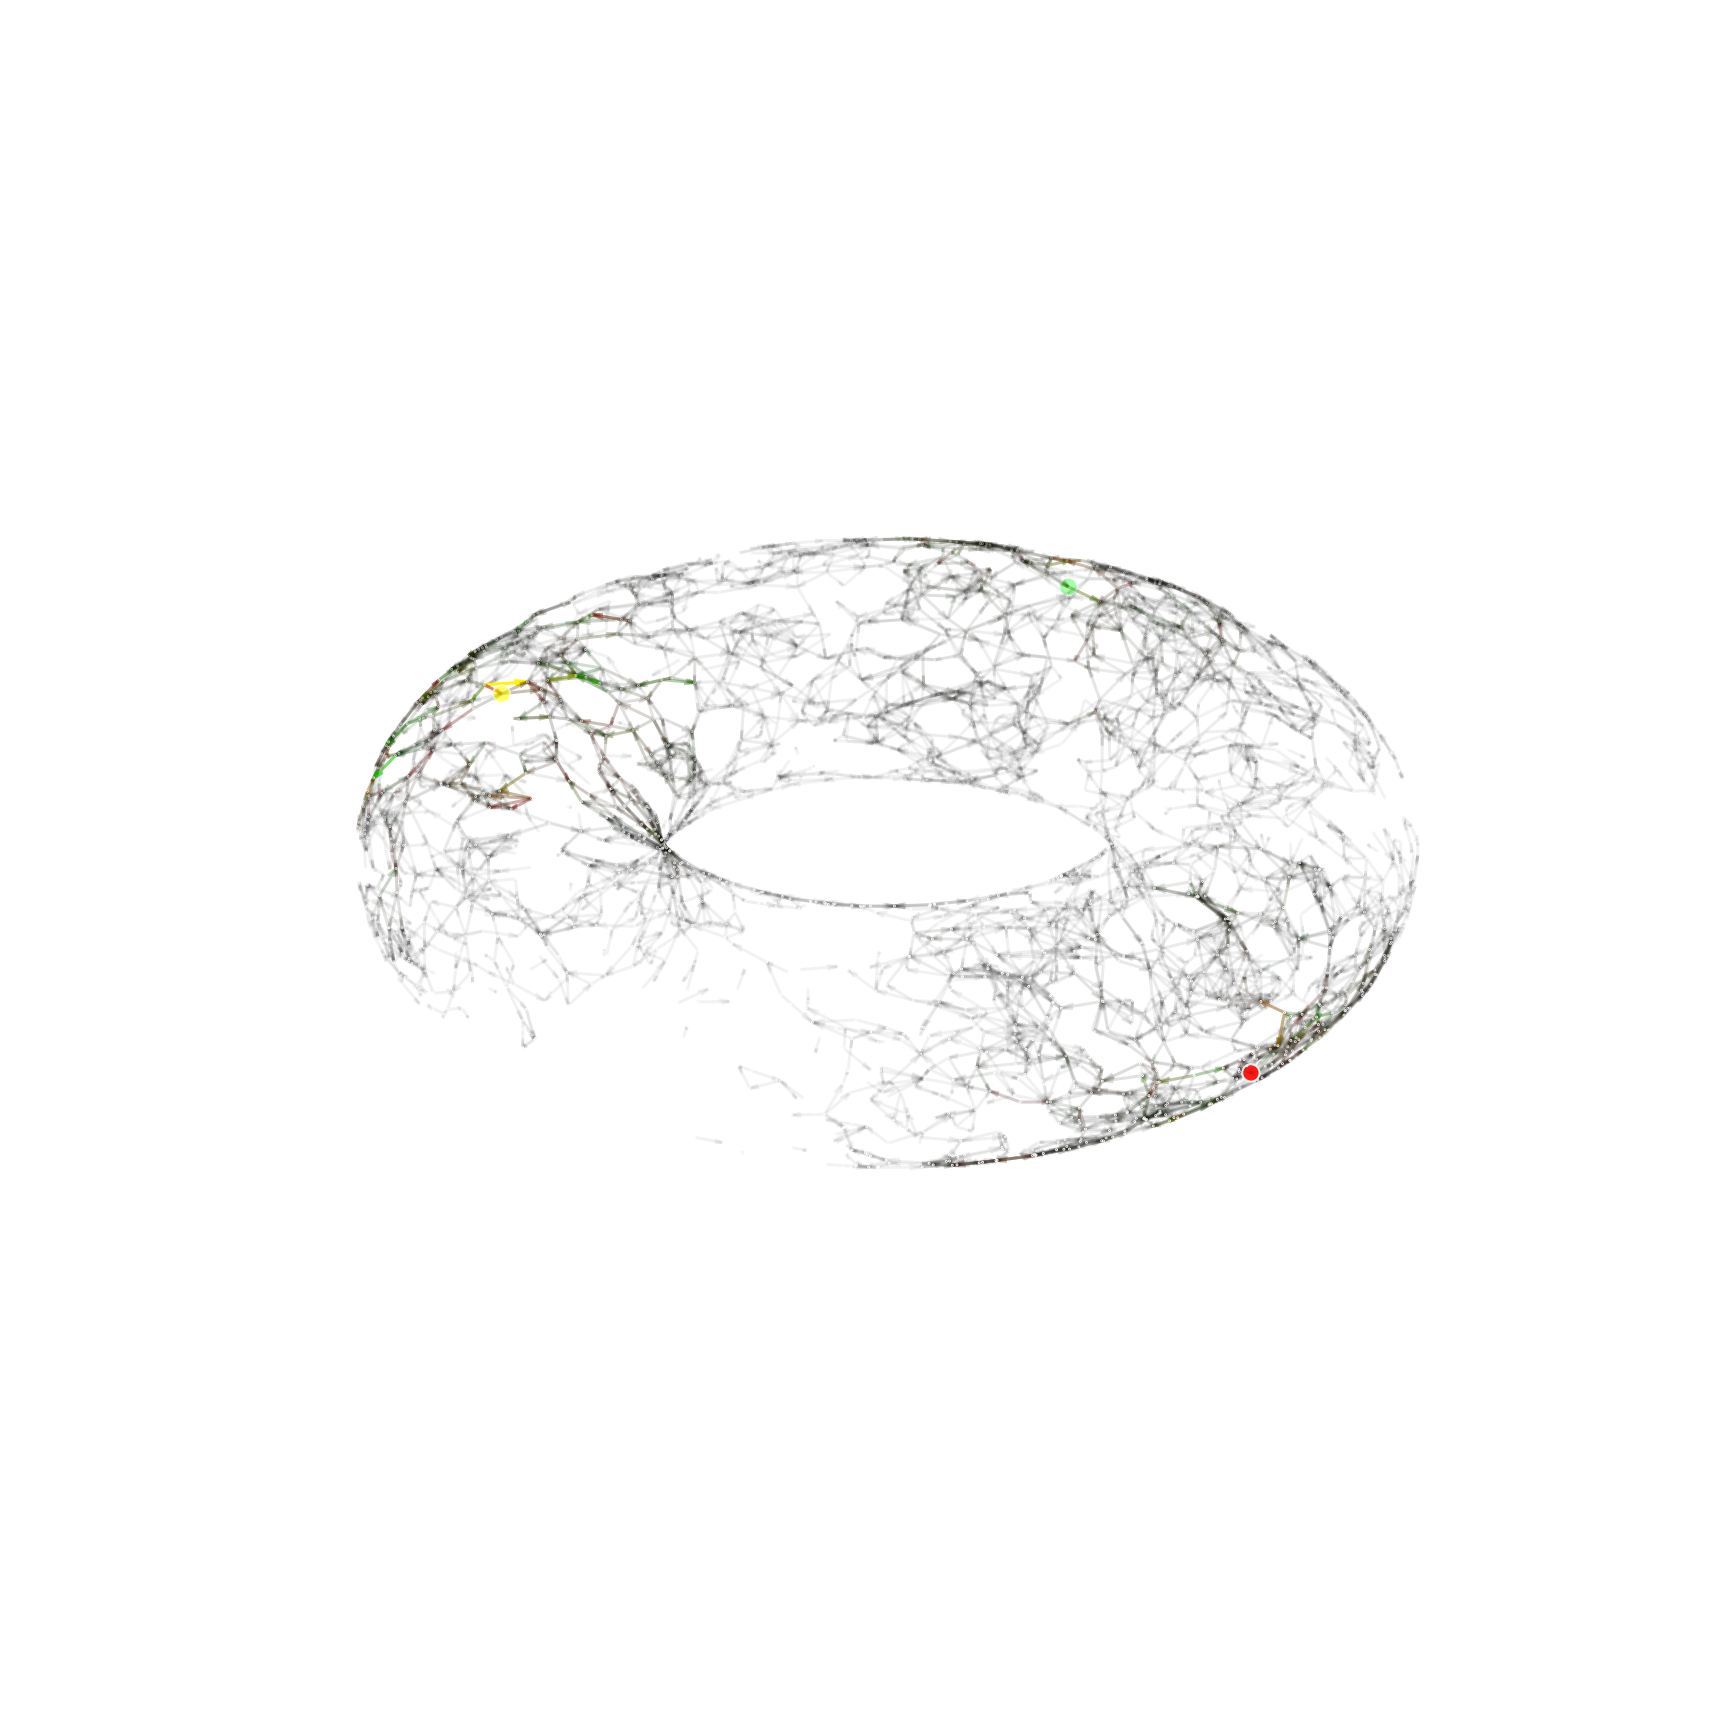

/tmp/ipykernel_71977/1841123288.py:32: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [66]:
%matplotlib notebook
node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300

node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,1,0,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,1,0,1]

mask = (edge_score > 0)
J_ = J[mask,:]
mJ_ = np.max(np.abs(J_))

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,0] = np.abs(J_[:,0])/mJ_
edge_color[mask,1] = np.abs(J_[:,1])/mJ_
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=5, figsize=(12, 12))
#plt.gca().view_init(elev=20, azim=-119)
visualize_.set_axes_equal(plt.gca())
plt.show()

# Plot optimal phi

In [67]:
node_color_ = phi.reshape((CG.number_of_nodes(), d))

<IPython.core.display.Javascript object>


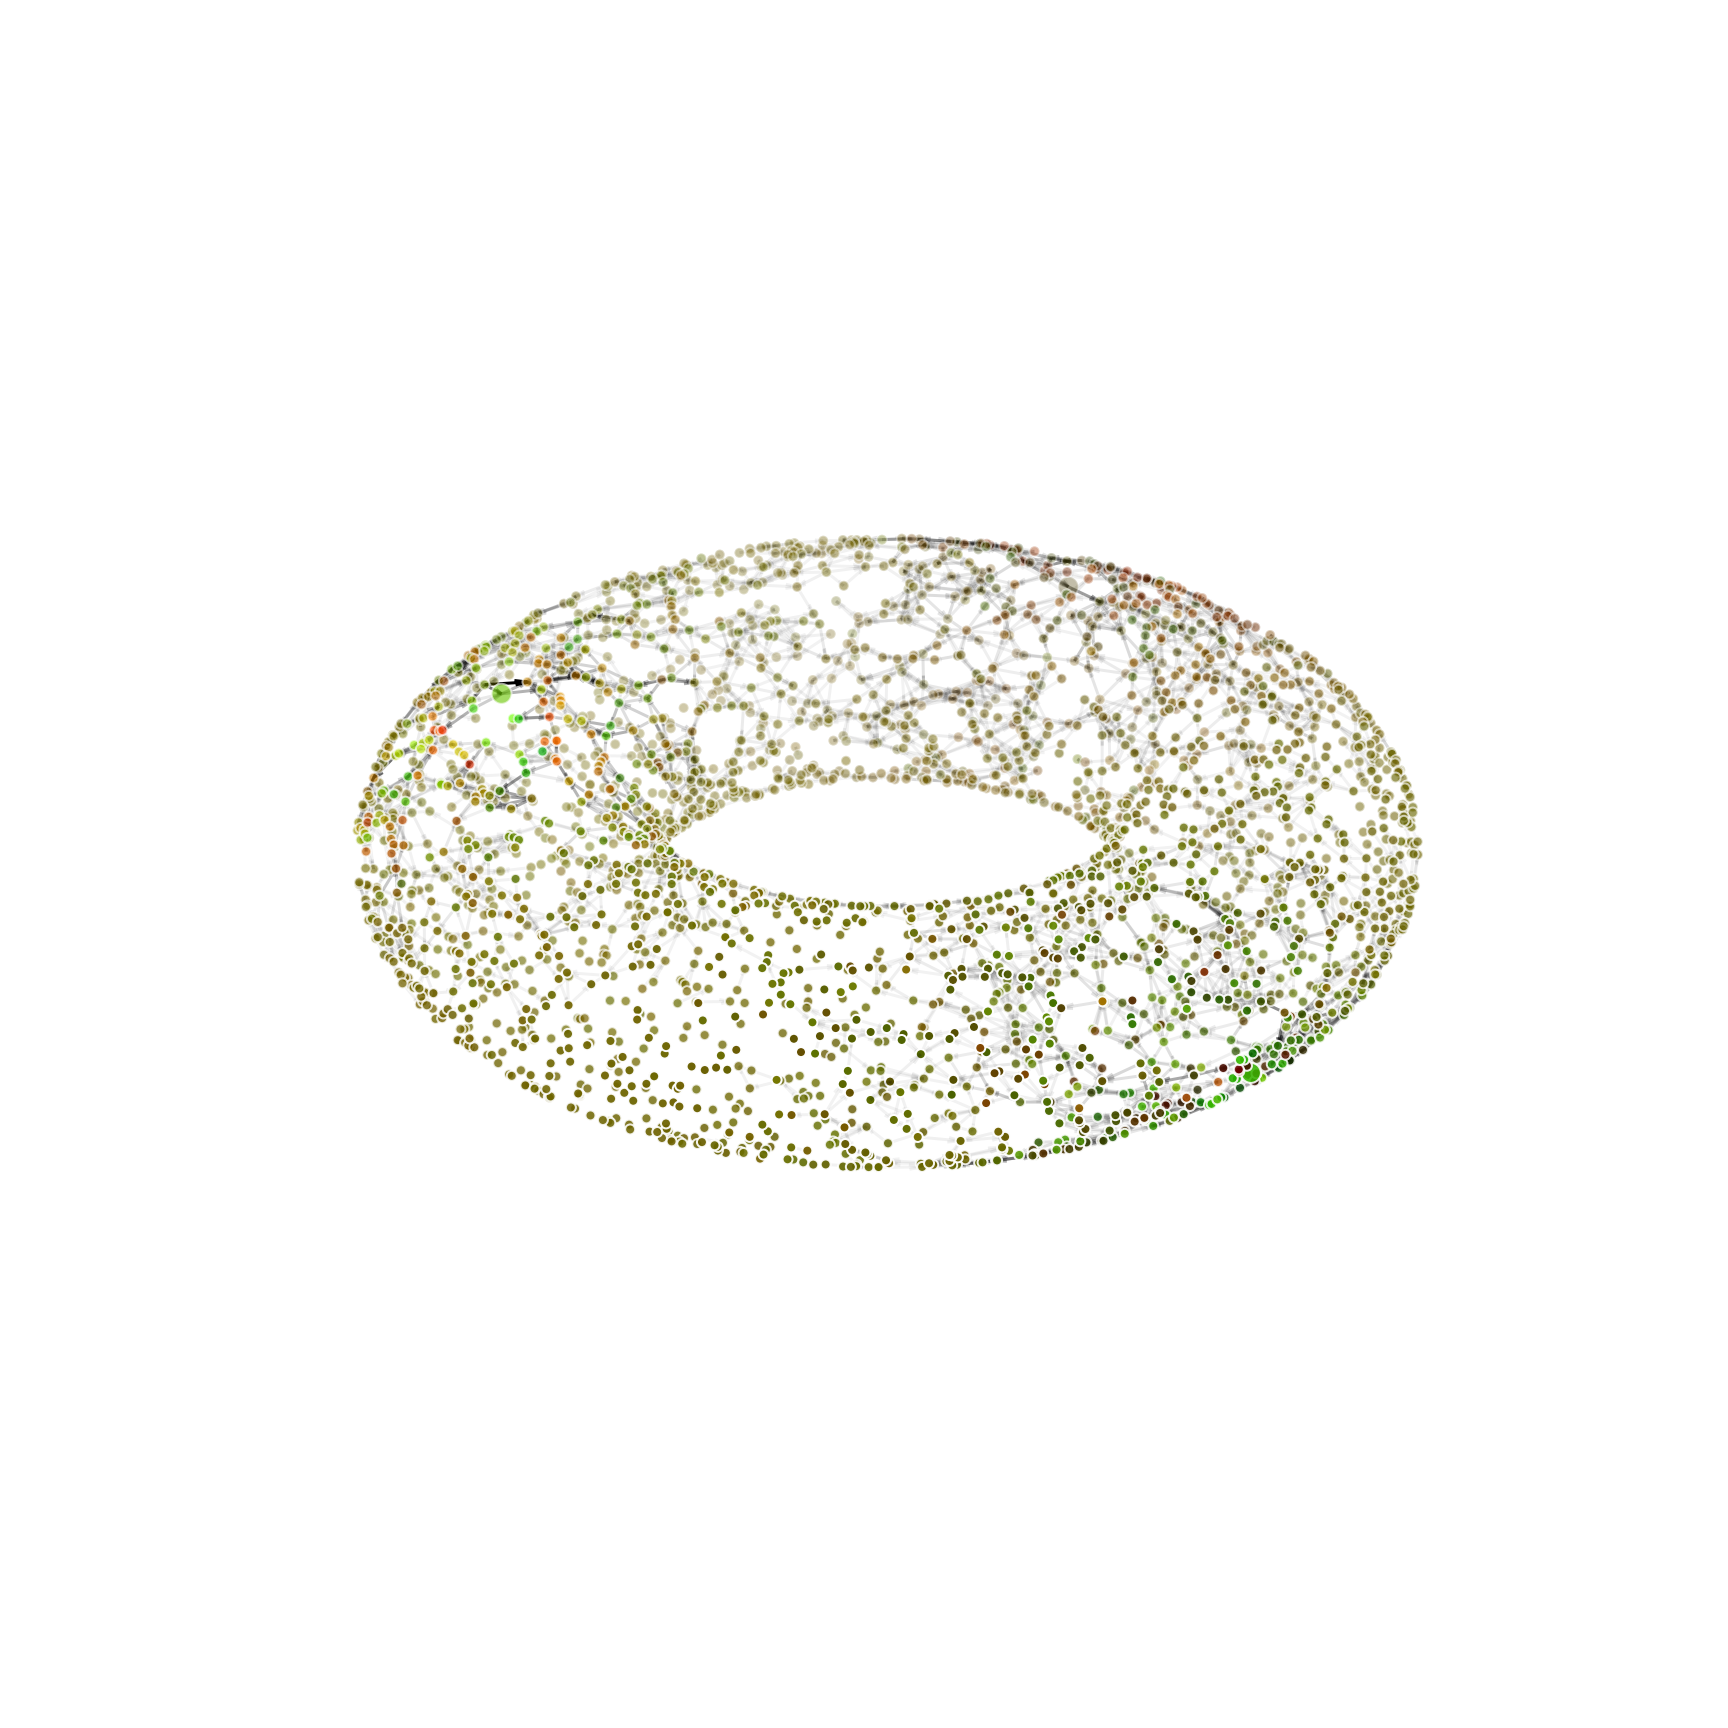

/tmp/ipykernel_71977/1841123288.py:32: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [68]:
%matplotlib notebook
node_size = np.ones(n)*100
node_size[source] = 400
node_size[dest1] = 400
node_size[dest2] = 400

node_color = np.zeros((n,4))
node_color[:,-1] = 1
node_color[:,0] = (node_color_[:,0] - np.min(node_color_[:,0]))/np.ptp(node_color_[:,0])
node_color[:,1] = (node_color_[:,1] - np.min(node_color_[:,1]))/np.ptp(node_color_[:,1])

mask = (edge_score > 0)

edge_color = np.zeros((edge_score.shape[0],4))
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=5, figsize=(12, 12))
#plt.gca().view_init(elev=20, azim=-119)
visualize_.set_axes_equal(plt.gca())
plt.show()